# Install important packages for boosted decision trees

In [2]:
!pip install lightgbm
!pip install shap

     |████████████████████████████████| 276kB 6.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394115 sha256=d457e47cb9b879ed3b83bd1f2b598f729413fab7b6e716fa13415eda482398a1
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


# Importing packages and defining functions and variables

In [3]:
%tensorflow_version 1.x
import lzma
from google.colab import drive
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import lightgbm as lgb#t
import shap
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
#from scipy import interp
from sklearn.metrics import roc_auc_score

def READ_XZ (filename):
    file = lzma.LZMAFile(filename)
    type_bytes = file.read(-1)
    type_array = np.frombuffer(type_bytes,dtype='float32')                                                
    return type_array

def Count(array,val):
  count = 0.0
  for e in range(array.shape[0]):
    if array[e]>val :
      count=count+1.0
  return count / array.shape[0]

width=40
batch_size=200
ModelName = "Model_40_24_8_24_40_40"

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
sess = tf.Session(config=config)
keras.backend.set_session(sess)
K.tensorflow_backend._get_available_gpus()

TensorFlow 1.x selected.


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

# Defining autoencoder model, Training and evaluation functions

In [4]:
# this is our input placeholder
input_img = Input(shape=(width*width,))

# "encoded" is the encoded representation of the input
Layer1 = Dense(24*24, activation='relu')(input_img)
Layer2 = Dense(8*8, activation='relu')(Layer1)
Layer3 = Dense(24*24, activation='relu')(Layer2)
Layer4 = Dense(40*40, activation='relu')(Layer3)
Out = Dense(40*40, activation='softmax')(Layer4)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, Out)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

def NAME(eventtype,purpose,i,obs) :
  return "./"+eventtype+"/"+purpose+"/"+obs+"."+str(i)+".bin.xz"
#

def EvalOnFile (InFileName,OutFileName):
  data = READ_XZ (InFileName)
  x_train = data.reshape(-1,width*width)
  x_out = autoencoder.predict(x_train,200,use_multiprocessing=True)
  diff = x_train - x_out
  lrnorm = np.ones((diff.shape[0]))
  for e in range(diff.shape[0]):
    lrnorm[e] = np.linalg.norm(diff[e])
  lrnorm.tofile(OutFileName)
  print(lrnorm.shape)
BATCH_SIZE=512
def TrainOnFile (filename,testfilename,totalepochs):
  data = READ_XZ (filename)
  x_train = data.reshape(-1,width*width)
  datatest = READ_XZ (testfilename)
  x_test = datatest.reshape(-1,width*width)
  autoencoder.fit(
      x_train, x_train, epochs=totalepochs,
      batch_size=BATCH_SIZE, shuffle=True,
      validation_data=(x_test, x_test)
  )
  autoencoder.save(ModelName)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Mount google drive to access data

Get the data from the link [https://drive.google.com/drive/folders/1_voPoiETqfWmCmBeUCKiF5oXqzbr-ZWt?usp=sharing] (this link is public and anyone can download the image data and trained models)

In [5]:
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


# Check the files exist and make a copy of the autoencoder model for backup

In [6]:
%cd /gdrive/My Drive/S2
!ls
!cp ./Model_40_24_8_24_40_40 ../Model_40_24_8_24_40_40.bak
!ls ../
# !tar -xf S2.tar

/gdrive/My Drive/S2
Model_40_24_8_24_40_40	QCD  TOP  topeff_loss
 anime		    DATA_SCIENCE_PROBLEM	 myget
'Colab Notebooks'   Model_40_24_8_24_40_40.bak	 programs.squashfs-xz
 DABBA_FOLDER	    myencoder			 S2


# CD to the main data directory and load the trained model

In [7]:
%cd /gdrive/My Drive/S2
autoencoder = keras.models.load_model(ModelName)

/gdrive/My Drive/S2



# Train another round if required

(You are strongly advised not to do this but to just use the trained model...)

In [0]:
%cd /gdrive/My Drive/S2
#autoencoder = keras.models.load_model(ModelName)
#!ls ./TOP/TRAIN/*.*.bin.xz
#

for e in range(20):
  for i in range(7):
    TrainOnFile(NAME("QCD","TRAIN",i%7,"out"),NAME("QCD","TEST",i%3,"out"),10)
  #
  for i in range(3):
    TrainOnFile(NAME("QCD","VAL",i%7,"out"),NAME("QCD","TEST",i%3,"out"),10)
  #
#

/gdrive/My Drive/S2
Train on 99999 samples, validate on 99996 samples
Epoch 1/10
99999/99999 [==============================] - 4s 36us/step - loss: 5.3439e-06 - val_loss: 6.0588e-06
Epoch 2/10
99999/99999 [==============================] - 3s 34us/step - loss: 5.2064e-06 - val_loss: 6.0297e-06
Epoch 3/10
99999/99999 [==============================] - 3s 34us/step - loss: 5.1515e-06 - val_loss: 6.0431e-06
Epoch 4/10
99999/99999 [==============================] - 3s 33us/step - loss: 5.1172e-06 - val_loss: 6.0204e-06
Epoch 5/10
99999/99999 [==============================] - 3s 33us/step - loss: 5.0928e-06 - val_loss: 6.0374e-06
Epoch 6/10
99999/99999 [==============================] - 3s 33us/step - loss: 5.0727e-06 - val_loss: 6.0436e-06
Epoch 7/10
99999/99999 [==============================] - 3s 34us/step - loss: 5.0526e-06 - val_loss: 6.0485e-06
Epoch 8/10
99999/99999 [==============================] - 3s 34us/step - loss: 5.0372e-06 - val_loss: 6.0457e-06
Epoch 9/10
99999/99999 [==

# Evaluation using the trained model

In [7]:
for i in range(7) :
  EvalOnFile(NAME("QCD","TRAIN",i,"out"),NAME("QCD","TRAIN",i,"loss"))
  EvalOnFile(NAME("TOP","TRAIN",i,"out"),NAME("TOP","TRAIN",i,"loss"))
#
for i in range(3) :
  EvalOnFile(NAME("QCD","TEST",i,"out"),NAME("QCD","TEST",i,"loss"))
  EvalOnFile(NAME("TOP","TEST",i,"out"),NAME("TOP","TEST",i,"loss"))
  EvalOnFile(NAME("QCD","VAL",i,"out"),NAME("QCD","VAL",i,"loss"))
  EvalOnFile(NAME("TOP","VAL",i,"out"),NAME("TOP","VAL",i,"loss"))
#

(99999,)
(100000,)
(99999,)
(100000,)
(99998,)
(100000,)
(99996,)
(100000,)
(100000,)
(100000,)
(99998,)
(100000,)
(5523,)
(5477,)
(99996,)
(100000,)
(99998,)
(100000,)
(99996,)
(100000,)
(99999,)
(100000,)
(1914,)
(2086,)
(1503,)
(1497,)


# Read the important data

Here, we read the autoencoder loss, jet mass and nsubjettiness (mass and nsubjettiness were evaluated using the C programs `main.cc`, `main.hh` and `all.hh` found in [https://github.com/aravindhv10/CPP_Wrappers/tree/master/AntiQCD4/ML4JETS] )

In [0]:
def ReadLossMassNsub(eventtype,sampletype,i):
  loss = np.fromfile(NAME(eventtype,sampletype,i,"loss"), dtype=float)
  mass = READ_XZ(NAME(eventtype,sampletype,i,"mass"))
  nsub = READ_XZ(NAME(eventtype,sampletype,i,"nsub")).reshape(-1,5)
  #print(nsub.shape)
  out = np.ones((mass.shape[0],7))
  for i in range(mass.shape[0]):
    out[i][0] = loss[i]
    out[i][1] = mass[i]
    out[i][2] = nsub[i][0]
    out[i][3] = nsub[i][1]
    out[i][4] = nsub[i][2]
    out[i][5] = nsub[i][3]
    out[i][6] = nsub[i][4]
  #
  return out
#

In [0]:
vars_qcd_train = ReadLossMassNsub("QCD","TRAIN",0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",1),0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",2),0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",3),0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",4),0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",5),0)
vars_qcd_train = np.append (vars_qcd_train,ReadLossMassNsub("QCD","TRAIN",6),0)

vars_qcd_test = ReadLossMassNsub("QCD","TEST",0)
vars_qcd_test = np.append (vars_qcd_test,ReadLossMassNsub("QCD","TEST",1),0)
vars_qcd_test = np.append (vars_qcd_test,ReadLossMassNsub("QCD","TEST",2),0)

vars_qcd_val = ReadLossMassNsub("QCD","VAL",0)
vars_qcd_val = np.append (vars_qcd_val,ReadLossMassNsub("QCD","VAL",1),0)
vars_qcd_val = np.append (vars_qcd_val,ReadLossMassNsub("QCD","VAL",2),0)

In [0]:
vars_top_train = ReadLossMassNsub("TOP","TRAIN",0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",1),0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",2),0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",3),0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",4),0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",5),0)
vars_top_train = np.append (vars_top_train,ReadLossMassNsub("TOP","TRAIN",6),0)

vars_top_test = ReadLossMassNsub("TOP","TEST",0)
vars_top_test = np.append (vars_top_test,ReadLossMassNsub("TOP","TEST",1),0)
vars_top_test = np.append (vars_top_test,ReadLossMassNsub("TOP","TEST",2),0)

vars_top_val = ReadLossMassNsub("TOP","VAL",0)
vars_top_val = np.append (vars_top_val,ReadLossMassNsub("TOP","VAL",1),0)
vars_top_val = np.append (vars_top_val,ReadLossMassNsub("TOP","VAL",2),0)

# Plotting and checking

## Plot $\epsilon$ (autoencoder loss)

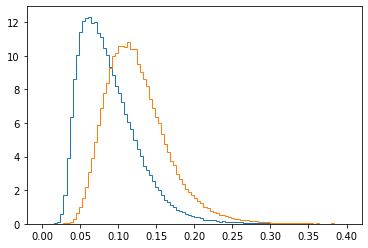

In [11]:
plt.hist(vars_qcd_test[:,0],100,(0.0,0.4),density=True,histtype='step')
plt.hist(vars_top_test[:,0],100,(0.0,0.4),density=True,histtype='step')
plt.show()

## Plot $m_J$ (jet mass)

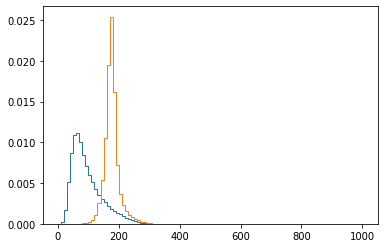

In [12]:
plt.hist(vars_qcd_test[:,1],100,(0.0,1000),density=True,histtype='step')
plt.hist(vars_top_test[:,1],100,(0.0,1000),density=True,histtype='step')
plt.show()

## Plot jet $\tau_1$ (nsubjettiness)

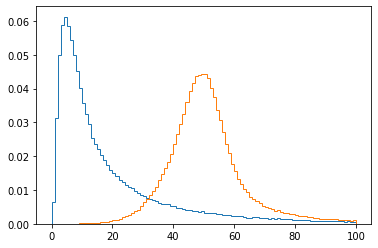

In [13]:
plt.hist(vars_qcd_test[:,2],100,(0.0,100),density=True,histtype='step')
plt.hist(vars_top_test[:,2],100,(0.0,100),density=True,histtype='step')
plt.show()

## Plot jet $\tau_2$ (nsubjettiness)

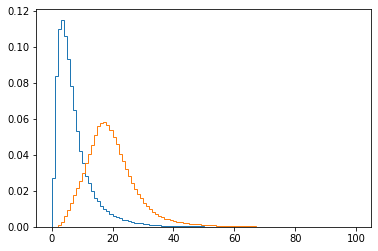

In [14]:
plt.hist(vars_qcd_test[:,3],100,(0.0,100),density=True,histtype='step')
plt.hist(vars_top_test[:,3],100,(0.0,100),density=True,histtype='step')
plt.show()

## Plot jet $\tau_3$ (nsubjettiness)

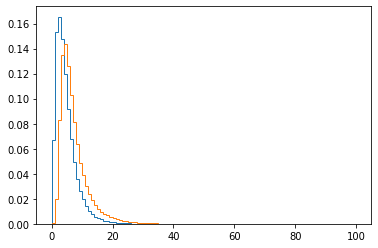

In [15]:
plt.hist(vars_qcd_test[:,4],100,(0.0,100),density=True,histtype='step')
plt.hist(vars_top_test[:,4],100,(0.0,100),density=True,histtype='step')
plt.show()

## Plot jet $\tau_4$ (nsubjettiness)

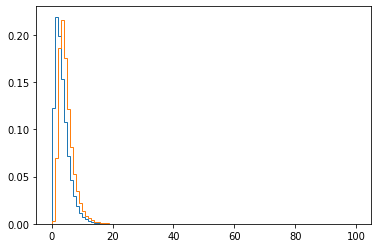

In [16]:
plt.hist(vars_qcd_test[:,5],100,(0.0,100),density=True,histtype='step')
plt.hist(vars_top_test[:,5],100,(0.0,100),density=True,histtype='step')
plt.show()

# Plot ROC using only $\epsilon$

X axis is $\epsilon_t$

Y axis is $\frac{1}{\epsilon_{\text{QCD}}}$

[<matplotlib.lines.Line2D at 0x7f83f96ba2b0>]

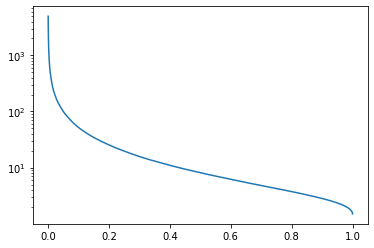

In [18]:
dx = (0.4 - 0.0) / 100.0
qcdeff = np.ones((100))
topeff = np.ones((100))
for i in range(100):
  xval = i*dx
  qcdeff[i]=1.0/(Count(vars_qcd_test[:,0],xval)+0.0000000001)
  topeff[i]=Count(vars_top_test[:,0],xval)
plt.yscale('log')
plt.plot(topeff,qcdeff)

# Combining variables
We now repeat the ROC exercise using boosted decision trees to combine the variables.

In [0]:
import sklearn
def prepare (qcd_vars,top_vars) :
  out_x = np.append(qcd_vars,top_vars,0)
  out_y = np.append(np.zeros((qcd_vars.shape[0]),dtype='float32'),np.ones((top_vars.shape[0]),dtype='float32'),0)
  return sklearn.utils.shuffle ( out_x , out_y , random_state=0 )

In [0]:
train_x, train_y = prepare(vars_qcd_train,vars_top_train)
test_x, test_y = prepare(vars_qcd_test,vars_top_test)
val_x, val_y = prepare(vars_qcd_val,vars_top_val)
param = { 'objective':'binary' , 'metric':'auc,binary_logloss,binary_error' }

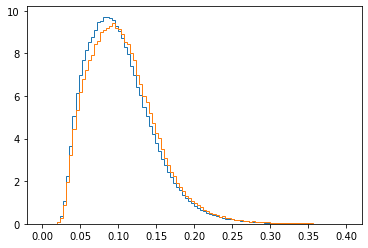

In [21]:
plt.hist(train_x[:,0],100,(0.0,0.4),density=True,histtype='step')
plt.hist(test_x[:,0],100,(0.0,0.4),density=True,histtype='step')
plt.show()

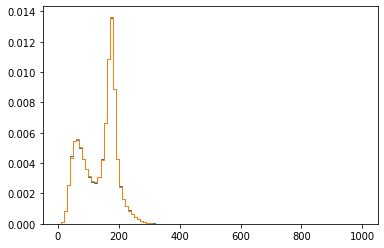

In [22]:
plt.hist(train_x[:,1],100,(0.0,1000),density=True,histtype='step')
plt.hist(test_x[:,1],100,(0.0,1000),density=True,histtype='step')
plt.show()

# Decision trees using only autoencoder loss

In [23]:
num_round = 100
#train_data = lgb.Dataset( train_x[:,0:0] , label=train_y )
#val_data   = lgb.Dataset( val_x[:,0:0]   , label=val_y   )
train_data = lgb.Dataset( train_x[:,0].reshape((-1,1)) , label=train_y )
val_data   = lgb.Dataset( val_x[:,0].reshape((-1,1))   , label=val_y   )
bst = lgb.train(param, train_data, num_round, valid_sets=val_data)
pred_qcd_test = bst.predict(vars_qcd_test[:,0].reshape((-1,1)))
pred_top_test = bst.predict(vars_top_test[:,0].reshape((-1,1)))

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


[1]	valid_0's binary_logloss: 0.662144	valid_0's binary_error: 0.246362	valid_0's auc: 0.833258
[2]	valid_0's binary_logloss: 0.636785	valid_0's binary_error: 0.246362	valid_0's auc: 0.83344
[3]	valid_0's binary_logloss: 0.615826	valid_0's binary_error: 0.246362	valid_0's auc: 0.833473
[4]	valid_0's binary_logloss: 0.598368	valid_0's binary_error: 0.246362	valid_0's auc: 0.83349
[5]	valid_0's binary_logloss: 0.583739	valid_0's binary_error: 0.246362	valid_0's auc: 0.83351
[6]	valid_0's binary_logloss: 0.571426	valid_0's binary_error: 0.246362	valid_0's auc: 0.833528
[7]	valid_0's binary_logloss: 0.561019	valid_0's binary_error: 0.246362	valid_0's auc: 0.833539
[8]	valid_0's binary_logloss: 0.552206	valid_0's binary_error: 0.246362	valid_0's auc: 0.833541
[9]	valid_0's binary_logloss: 0.544718	valid_0's binary_error: 0.246362	valid_0's auc: 0.833547
[10]	valid_0's binary_logloss: 0.538346	valid_0's binary_error: 0.246362	valid_0's auc: 0.833555
[11]	valid_0's binary_logloss: 0.532917	va

## Plot the ROC from the above model

[<matplotlib.lines.Line2D at 0x7f83f94876a0>]

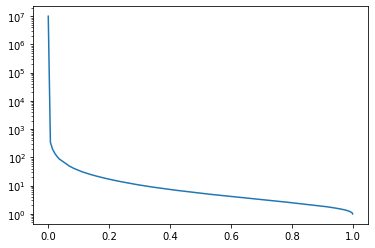

In [24]:
epsilon = 0.0000001
num = 1000
dx = ( 1.0 + (epsilon*2) ) / num
qcdeff_loss = np.ones((num))
topeff_loss = np.ones((num))
for i in range(num):
  xval = (i*dx) - epsilon
  qcdeff_loss[i]=1.0/(Count(pred_qcd_test,xval)+epsilon)
  topeff_loss[i]=Count(pred_top_test,xval)
plt.yscale('log')
plt.plot(topeff_loss,qcdeff_loss)

# Train BDT using all variables

In [28]:
num_round = 100
train_data = lgb.Dataset( train_x[:,0:6] , label=train_y )
val_data   = lgb.Dataset( val_x[:,0:6]   , label=val_y   )
bst = lgb.train(param, train_data, num_round, valid_sets=val_data)
pred_qcd_test = bst.predict(vars_qcd_test[:,0:6])
pred_top_test = bst.predict(vars_top_test[:,0:6])

[1]	valid_0's binary_logloss: 0.622961	valid_0's binary_error: 0.0853604	valid_0's auc: 0.966623
[2]	valid_0's binary_logloss: 0.565327	valid_0's binary_error: 0.0832066	valid_0's auc: 0.96846
[3]	valid_0's binary_logloss: 0.517087	valid_0's binary_error: 0.0829262	valid_0's auc: 0.970094
[4]	valid_0's binary_logloss: 0.476226	valid_0's binary_error: 0.0813306	valid_0's auc: 0.971207
[5]	valid_0's binary_logloss: 0.441305	valid_0's binary_error: 0.0809361	valid_0's auc: 0.972396
[6]	valid_0's binary_logloss: 0.411219	valid_0's binary_error: 0.0803058	valid_0's auc: 0.97309
[7]	valid_0's binary_logloss: 0.385232	valid_0's binary_error: 0.0796929	valid_0's auc: 0.973353
[8]	valid_0's binary_logloss: 0.362555	valid_0's binary_error: 0.0791569	valid_0's auc: 0.973636
[9]	valid_0's binary_logloss: 0.342904	valid_0's binary_error: 0.0791941	valid_0's auc: 0.973917
[10]	valid_0's binary_logloss: 0.325526	valid_0's binary_error: 0.078807	valid_0's auc: 0.974135
[11]	valid_0's binary_logloss: 0

## Plot ROC using above model

[<matplotlib.lines.Line2D at 0x7f83f8910198>]

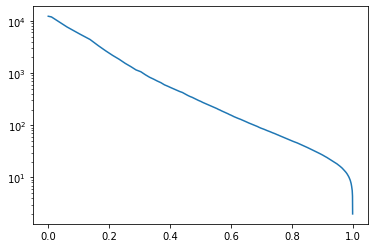

In [30]:
epsilon = 0.0000001
num = 1000
dx = ( 1.0 + (epsilon*2) ) / num
qcdeff_all = np.ones((num))
topeff_all = np.ones((num))
for i in range(num):
  xval = (i*dx) - epsilon
  qcdeff_all[i]=1.0/(Count(pred_qcd_test,xval)+epsilon)
  topeff_all[i]=Count(pred_top_test,xval)
plt.yscale('log')
plt.plot(topeff_all,qcdeff_all)

# Not using the autoencoder loss

In [31]:
num_round = 100
train_data = lgb.Dataset( train_x[:,1:6] , label=train_y )
val_data   = lgb.Dataset( val_x[:,1:6]   , label=val_y   )
bst = lgb.train(param, train_data, num_round, valid_sets=val_data)
pred_qcd_test = bst.predict(vars_qcd_test[:,1:6])
pred_top_test = bst.predict(vars_top_test[:,1:6])

[1]	valid_0's binary_logloss: 0.623859	valid_0's binary_error: 0.0913977	valid_0's auc: 0.963412
[2]	valid_0's binary_logloss: 0.567135	valid_0's binary_error: 0.0903108	valid_0's auc: 0.965867
[3]	valid_0's binary_logloss: 0.519743	valid_0's binary_error: 0.0886483	valid_0's auc: 0.967105
[4]	valid_0's binary_logloss: 0.479773	valid_0's binary_error: 0.0884746	valid_0's auc: 0.967698
[5]	valid_0's binary_logloss: 0.445674	valid_0's binary_error: 0.0876632	valid_0's auc: 0.968226
[6]	valid_0's binary_logloss: 0.416379	valid_0's binary_error: 0.0875987	valid_0's auc: 0.968576
[7]	valid_0's binary_logloss: 0.391039	valid_0's binary_error: 0.0869039	valid_0's auc: 0.968837
[8]	valid_0's binary_logloss: 0.369023	valid_0's binary_error: 0.0863853	valid_0's auc: 0.969173
[9]	valid_0's binary_logloss: 0.349887	valid_0's binary_error: 0.0861867	valid_0's auc: 0.969489
[10]	valid_0's binary_logloss: 0.333154	valid_0's binary_error: 0.0858468	valid_0's auc: 0.969647
[11]	valid_0's binary_logloss

## Plot ROC for above model

[<matplotlib.lines.Line2D at 0x7f83f9de0d68>]

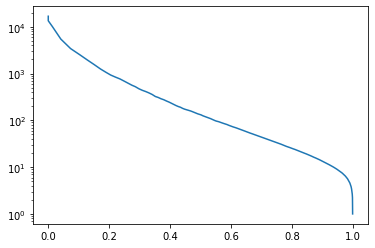

In [32]:
epsilon = 0.0000001
num = 1000
dx = ( 1.0 + (epsilon*2) ) / num
qcdeff_noloss = np.ones((num))
topeff_noloss = np.ones((num))
for i in range(num):
  xval = (i*dx) - epsilon
  qcdeff_noloss[i]=1.0/(Count(pred_qcd_test,xval)+epsilon)
  topeff_noloss[i]=Count(pred_top_test,xval)
plt.yscale('log')
plt.plot(topeff_noloss,qcdeff_noloss)

In [0]:
np.savetxt("topeff_loss",topeff_loss)
np.savetxt("qcdeff_loss",qcdeff_loss)
np.savetxt("topeff_all",topeff_all)
np.savetxt("qcdeff_all",qcdeff_all)
np.savetxt("topeff_noloss",topeff_noloss)
np.savetxt("qcdeff_noloss",qcdeff_noloss)